# TODO
- Implement ConvNet model
- Implement loading of CIFAR10 dataset
- Write training scheme for the buffer
- Write training scheme for the distillation

# Dataset Distillation by Matching Training Trajectories

Implementation of the MTT method, based on the [code by the paper's authors](https://github.com/GeorgeCazenavette/mtt-distillation/tree/main). This implementation uses Jupyter notebooks to visualize the model, and is also not dependent on any online services like in the original implementation.

- Model used: ConvNet (as implemented by the MTT paper)
- Dataset used: CIFAR10, CIFAR100

To get started, you can run the notebook as is, or modify settings the User Settings section.


## Setup

The following cells will import important packages, configure devices, load TensorBoard etc

In [90]:
import sys
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [91]:
# Set up device
# TODO: this should be the only switch to decide if we use CUDA or CPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device being used: {device}")

# For debugging CUDA, we can record memory history
# if torch.cuda.is_available():
#     torch.cuda.memory._record_memory_history()

device being used: cuda


In [92]:
# Set up Matplotlib so that it properly visualizes inside Jupyter notebook using VSCode

plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

In [93]:
# Some small fixes to prevent Jupyter from bugging out

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# To prevent the kernel from dying.
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
# Set up TensorBoard

""" Notes on superbuggy VSCode tensorboard

The general conclusion is that Tensorboard in VSCode breaks regularly for whatever reasons, and nobody
cares to fix it. So just use Tensboard from the browser. Code below will run tensorboard on port 6006

For some reason tensorboard isn't quitting properly, and keeps the port occupied even
if the process itself is killed. Maybe it will be patched someday...

1. Check Code Python Interpreter is correct

2. Check if port occupied:
lsof -i:6006

Kill using the PID from above command (not 6006, the PID!):
kill PID

See https://stackoverflow.com/questions/54395201/tensorboard-could-not-bind-to-port-6006-it-was-already-in-use
Also, see this on how to kill tensorboard process (but not the problem here): https://stackoverflow.com/questions/36896164/tensorflow-how-to-close-tensorboard-server

3. Alternative if you want to see tensorboard in a webbrowser (6006, 8888 etc):
tensorboard --logdir=data/ --host localhost --port 6006
http//localhost:6006

Another possible bug is that installing tensorboard with conda is not visible in Jupyter Notebooks using VSCode. You will have to reinstall it using pip instead

"""

%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir=logs/ --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12721), started 0:37:16 ago. (Use '!kill 12721' to kill it.)

# User Settings

Here you can define the most important aspects of the notebook.

In [110]:
from torchvision.datasets import CIFAR10, CIFAR100

# User settings:
settings = {
    "dataset": "CIFAR10",  # [CIFAR10, CIFAR100]
    "model": "ConvNet",  # [ConvNet, ResNet]
    "ZCA": False,  # [True, False]
}


# Hyperparameters
hparams = {
    # General hyperparameters
    "device": device,
    "num_workers": 16,
    "epochs": 2,
    "batch_size": 16,
    "max_patience": 3,
    "learning_rate": 0.01,
    "weight_decay": 0.0,
    "momentum": 0.0,
    # Model specific hyperparameters
    "in_channels": 3,
    "out_channels": 10,
    "net_depth": 3,
    "net_width": 128,
    "kernel_size": 3,
    "padding": 1,
    "activation": nn.ReLU(inplace=True),
    "norm": nn.GroupNorm(
        num_groups=3, num_channels=3, affine=True
    ),  # group and channels should be equal to in_channels? Check
    "pooling": nn.AvgPool2d(kernel_size=2, stride=2),
    "optimizer": "SGD",
}

# Download and prepare dataset

The models used in this notebook are already provided by PyTorch itself, so we can simply download and modify them. However, the PyTorch class not accept slice indexes, so we will have to write our own little version on top of it which fixes the __getitem__ method. That way, we can do something like train_dataset[0:3] and not just train_dataset[1],

In [96]:
from pathlib import Path
from typing import Any, Callable, Tuple



class FixedCIFAR10(CIFAR10):
    def __init__(
        self,
        root: str | Path,
        train: bool = True,
        transform: Callable[..., Any] | None = None,
        target_transform: Callable[..., Any] | None = None,
        download: bool = False,
    ) -> None:
        # Initialization does not need to be changed
        super().__init__(root, train, transform, target_transform, download)

    def __getitem__(self, key):
        if isinstance(key, slice):
            return [self[i] for i in range(*key.indices(len(self)))]
        else:
            return super().__getitem__(key)

In [97]:
from torchvision import transforms

train_dataset = None
# val_dataset = None
test_dataset = None

if settings["dataset"] == "CIFAR10":
    if settings["ZCA"]:
        raise NotImplementedError("ZCA not yet implemented")
    else:
        # Normalize CIFAR10 dataset (Note: not same as those used in MTT repo, these were calculated directly from
        # the PyTorch CIFAR10 dataset itself)
        mean = np.array([0.49191375, 0.48235852, 0.44673872])
        std = np.array([0.24706447, 0.24346213, 0.26147554])
        transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]
        )

    print(f"Loading training dataset ({settings["dataset"]})")
    train_dataset = FixedCIFAR10(
        root="data/CIFAR10", train=True, download=True, transform=transform
    )

    print(f"Loading testing dataset ({settings["dataset"]})")
    test_dataset = FixedCIFAR10(
        root="data/CIFAR10", train=False, download=True, transform=transform
    )

else:
    raise ValueError(f"Unknown dataset defined by user: {settings["dataset"]}")

assert train_dataset != None and test_dataset != None

Loading training dataset (CIFAR10)
Files already downloaded and verified
Loading testing dataset (CIFAR10)
Files already downloaded and verified


In [98]:
# Show some basic information about the dataset

print("Training set size: %i" % len(train_dataset))
# print("Validation set size: %i" % len(val_dataset))
print("Test set size: %i" % len(test_dataset))

first_image, first_target = train_dataset[0]
print(f"Image dimensions: {first_image.shape}")  # C * W * H (C = 3 because RGB)
print(f"Target type: {type(first_target)}")
print(f"First image tensor: \n {first_image}")

Training set size: 50000
Test set size: 10000
Image dimensions: torch.Size([3, 32, 32])
Target type: <class 'int'>
First image tensor: 
 tensor([[[-1.0545e+00, -1.3085e+00, -1.1974e+00,  ...,  5.1685e-01,
           4.2161e-01,  3.5812e-01],
         [-1.7371e+00, -1.9910e+00, -1.7053e+00,  ..., -3.8698e-02,
          -1.0219e-01, -5.4570e-02],
         [-1.5942e+00, -1.7371e+00, -1.2133e+00,  ..., -1.1806e-01,
          -8.6316e-02, -2.6091e-01],
         ...,
         [ 1.3105e+00,  1.1994e+00,  1.1518e+00,  ...,  5.4859e-01,
          -1.1022e+00, -1.1498e+00],
         [ 8.6604e-01,  7.5494e-01,  9.6128e-01,  ...,  9.2953e-01,
          -4.5139e-01, -6.7360e-01],
         [ 8.1843e-01,  6.7557e-01,  8.5017e-01,  ...,  1.4375e+00,
           4.0574e-01, -3.8698e-02]],

        [[-9.8258e-01, -1.2403e+00, -1.2081e+00,  ...,  1.4494e-01,
           3.2192e-02,  1.6085e-02],
         [-1.6591e+00, -1.9812e+00, -1.8524e+00,  ..., -5.6379e-01,
          -6.4432e-01, -5.7989e-01],
       

In [108]:
# Function to visualize data
from torch import Tensor
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

# TODO: use torch.tensor.view instead of transpose when possible

def visualize_imgs(images: Tensor | List[Tensor]):
    if isinstance(images, Tensor):
        images = [images]

    n = len(images)
    plt.figure(figsize=(20, 3 * n))

    for idx, (image, targets) in enumerate(images):
        # Normalized input image
        plt.subplot(n, 1, idx * 1 + 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.axis("off")
        plt.title("Input image")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


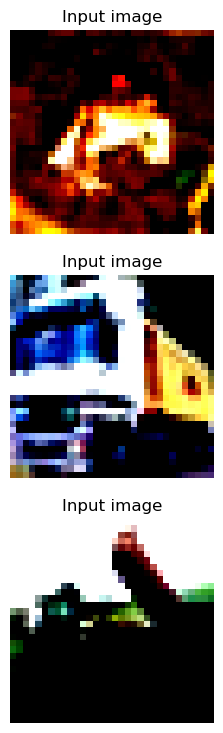

In [109]:
# Show some of the dataset. Note that normalization means the values are no longer in the range of 0-1, so
# there will be clipping warnings.

ex_imgs = train_dataset[0:3]

visualize_imgs(ex_imgs)

TODO:

- Create model
- Create tensor that uses one hot encoding for ids, not just a flat image
- Use a UNet
- Create trainer (use dataloader, load to device)
- Use a good loss function

# Design of Model

In [29]:
# Helper Classes for our model


class ConvSandwich(nn.Module):
    """
    Helper Class that creates a Convolution Layer with model specific hyperparameters
    """

    def __init__(self, hparams):
        super().__init__()
        self.conv = nn.Conv2d(
            hparams["in_channels"],
            hparams["out_channels"],
            hparams["kernel_size"],
            padding=hparams["padding"],
        )
        self.norm = hparams["norm"]
        self.activation = hparams["activation"]
        self.pooling = hparams["pooling"]

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        x = self.pooling(x)
        return x


class PrintLayer(nn.Module):
    """
    Helper Class for debugging behaviour of model. Will print out the shape of the layer input,
    and input passed directly to output
    """

    def forward(self, x):
        print(x.shape)
        # print("MODEL DATA ON: ", x.get_device(), "MODEL PARAMS ON: ", self.classifier.weight.data.get_device())
        return x


def weights_init(m):
    """
    Initialize weights for each layer of model m, based on the type of activation function
    """
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity="relu")
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_uniform_(m.weight, mode="fan_out", nonlinearity="relu")
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, hparams) -> None:
        super().__init__()

        self.hp = hparams
        self.kernel_size = self.hp["kernel_size"]  # used very often

        self.features = nn.ModuleList(
            [
                ConvSandwich(self.hparams),
                ConvSandwich(self.hparams),
                ConvSandwich(self.hparams),
            ]
        )

        self.classifier = nn.Linear(
            self.hp["in_channels"] * self.hp["in_channels"] * self.hp["in_channels"],
            self.hp["out_channels"],
        )

        # We want the model to be stored on GPU if possible
        self.device = hparams["device"]

        self.set_optimizer()

        # Apply initial weights
        # self.encoder.apply(weights_init)
        # self.decoder.apply(weights_init)
        # self.classifier.apply(weights_init)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

    def set_optimizer(self):
        self.optimizer = None

        if self.hp == "SGD":
            self.optimizer = torch.optim.SGD(
                self.parameters(),
                lr=self.hp["learning_rate"],
                momentum=self.hp["momentum"],
                weight_decay=self.hp["weight_decay"],
            )
        else:
            raise ValueError(f"Unexpected Optimizer chosen: {self.hp}")

    def training_step(self, batch, loss_func):
        self.train() # Set model to training mode
        self.optimizer.zero_grad()  # Reset gradient every batch

        # N = batch size, C = channels (3 for RGB), H = image height, W = image width
        images = batch[0].to(self.device)  # Input batch, N x C x H x W
        target = (
            batch[1][0].to(self.device).squeeze()
        )

        # Model makes prediction (forward pass)
        pred = self.forward(images)  # N x C x H x W (C=num of CityScape classes)

        # Calculate loss, do backward pass to update weights, optimizer takes step
        # torch.nn.CrossEntropyLoss(ignore_index=0, reduction="mean") wants target to be of type long, not float
        loss = loss_func(pred, target)
        loss.backward()
        self.optimizer.step()

        return loss

    def validation_step(self, batch, loss_func):
        loss = 0

        # Set model to eval
        self.eval()

        with torch.no_grad():
            images = batch[0].to(self.device)  # Input batch, N x C x H x W
            target = (
                batch[1][0].to(self.device).squeeze()
            )  # Ground truth, each pixel assigned an ID int. N x H x W

            pred = self.forward(images)
            loss = loss_func(pred, target)

        return loss

In [30]:
# Encoder and Decoder

"""
TODO:
- Optimizer only train encoder or decoder
- Make my own model
- Use PyTorch optimizations from their guide
"""


class SegmentationNN(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.hp = hparams
        self.kernel_factor = self.hp[
            "kernel_factor"
        ]  # Reuse this value often, so don't search a Dict

        """"
        General structure of the model:

        - encoder_block downsamples inputs and learns key features. Intermediate outputs are stored
        and used by the decoder block
        - decoder_block: Upsamples the low dimensional outputs of the encoder_block, essentially
        'learns' how things should look, and reconstructs the full segmented image
        - classifier
        """
        self.encoder = nn.ModuleList(
            [
                ConvSandwich(
                    3, self.kernel_factor, 3, 1, 1
                ),  # RGB image input has 3 channels
                ConvSandwich(self.kernel_factor, self.kernel_factor * 2, 3, 1, 1),
                ConvSandwich(self.kernel_factor * 2, self.kernel_factor * 4, 3, 1, 1),
                ConvSandwich(self.kernel_factor * 4, self.kernel_factor * 4, 3, 1, 1),
                ConvSandwich(self.kernel_factor * 4, self.kernel_factor * 8, 3, 1, 1),
            ]
        )

        self.decoder = nn.ModuleList(
            [
                ConvSandwich(
                    self.kernel_factor * (8 + 8), self.kernel_factor * 4, 3, 1, 1
                ),
                ConvSandwich(
                    self.kernel_factor * (4 + 4), self.kernel_factor * 4, 3, 1, 1
                ),
                ConvSandwich(
                    self.kernel_factor * (4 + 4), self.kernel_factor * 2, 3, 1, 1
                ),
                ConvSandwich(self.kernel_factor * (2 + 2), self.kernel_factor, 3, 1, 1),
            ]
        )

        self.classifier = nn.Conv2d(
            self.kernel_factor * 2 + 3, self.hp["output_size"], kernel_size=3, padding=1
        )

        self.downsample = nn.MaxPool2d(
            kernel_size=2, stride=2
        )  # Layer reused for downsampling
        self.upsample = nn.Upsample(
            scale_factor=2, mode="bicubic"
        )  # Layer reused for upsampling

        # self.print = PrintLayer()  # Used for debugging

        # We want the model to be stored on GPU if possible
        self.device = hparams.get(
            "device", torch.device("cuda" if torch.cuda.is_available() else "cpu")
        )
        self.set_optimizer()

        # Apply initial weights
        self.encoder.apply(weights_init)
        self.decoder.apply(weights_init)
        self.classifier.apply(weights_init)

    def forward(self, x):
        # Unet network

        # Note: need to use multiples of 2 or else rounding makes torch.cat try to concat tensors
        # of different sizes

        proc_x = self.encoder[0](x)
        enc_1 = self.encoder[1](proc_x)
        tmp = self.downsample(enc_1)
        enc_2 = self.encoder[2](tmp)
        tmp = self.downsample(enc_2)
        enc_3 = self.encoder[3](tmp)
        tmp = self.downsample(enc_3)
        enc_4 = self.encoder[4](tmp)

        bottleneck = self.downsample(enc_4)

        tmp = self.upsample(bottleneck)
        dec = self.decoder[0](torch.cat([tmp, enc_4], dim=1))
        tmp = self.upsample(dec)
        dec = self.decoder[1](torch.cat([tmp, enc_3], dim=1))
        tmp = self.upsample(dec)
        dec = self.decoder[2](torch.cat([tmp, enc_2], dim=1))
        tmp = self.upsample(dec)
        dec = self.decoder[3](torch.cat([tmp, enc_1], dim=1))
        tmp = self.upsample(dec)

        dec = torch.cat([dec, proc_x], dim=1)
        dec = torch.cat([dec, x], dim=1)
        x = self.classifier(dec)

        return x

    def set_optimizer(self):
        self.optimizer = None

        self.optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hp["learning_rate"],
            weight_decay=self.hp["weight_decay"],
        )

    def training_step(self, batch, loss_func):
        self.train()
        self.optimizer.zero_grad()  # Reset gradient every batch

        # N = batch size, C = channels (3 for RGB), H = image height, W = image width
        images = batch[0].to(self.device)  # Input batch, N x C x H x W
        target = (
            batch[1][0].to(self.device).squeeze()
        )  # Ground truth, each pixel assigned an ID int. N x H x W

        # Model makes prediction (forward pass)
        pred = self.forward(images)  # N x C x H x W (C=num of CityScape classes)

        # Calculate loss, do backward pass to update weights, optimizer takes step
        # torch.nn.CrossEntropyLoss(ignore_index=0, reduction="mean") wants target to be of type long, not float
        loss = loss_func(pred, target)
        loss.backward()
        self.optimizer.step()

        return loss

    def validation_step(self, batch, loss_func):
        loss = 0

        # Set model to eval
        self.eval()

        with torch.no_grad():
            images = batch[0].to(self.device)  # Input batch, N x C x H x W
            target = (
                batch[1][0].to(self.device).squeeze()
            )  # Ground truth, each pixel assigned an ID int. N x H x W

            pred = self.forward(images)
            loss = loss_func(pred, target)

        return loss

# Train Model

In [31]:
# Hyperparameters
# TODO: play around more with parameters to see if there is better solution

Since this is just for demonstration purposes, let us make sure the model is not too big. We want to be able to run it on something like a CPU even if we don't have access to a GPU! A parameter size of 25MB seems to be good enough to get this model working on a mid tier desktop CPU.

In [32]:
from torchinfo import summary

model = SegmentationNN(hparams=hparams)
summary(
    model,
    input_size=(
        hparams["batch_size"],
        3,
        hparams["input_size"][0],
        hparams["input_size"][1],
    ),
)

Layer (type:depth-idx)                   Output Shape              Param #
SegmentationNN                           [16, 35, 64, 32]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─ConvSandwich: 2-1                 [16, 8, 64, 32]           --
│    │    └─Conv2d: 3-1                  [16, 8, 64, 32]           216
│    │    └─BatchNorm2d: 3-2             [16, 8, 64, 32]           16
│    │    └─LeakyReLU: 3-3               [16, 8, 64, 32]           --
│    └─ConvSandwich: 2-2                 [16, 16, 64, 32]          --
│    │    └─Conv2d: 3-4                  [16, 16, 64, 32]          1,152
│    │    └─BatchNorm2d: 3-5             [16, 16, 64, 32]          32
│    │    └─LeakyReLU: 3-6               [16, 16, 64, 32]          --
├─MaxPool2d: 1-2                         [16, 16, 32, 16]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─ConvSandwich: 2-3                 [16, 32, 32, 16]      

In [33]:
# For debugging CUDA

# print(torch.cuda.memory_allocated() / 1000**2)
# print(torch.cuda.memory_reserved() / 1024**2)

# torch.cuda.memory._dump_snapshot("debug/pretraining_memory_usage.pickle")

In [34]:
import torch
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


def create_tqdm_bar(iterable, desc):
    return tqdm(enumerate(iterable), total=len(iterable), ncols=150, desc=desc)


def train_model(
    model, train_loader, val_loader, loss_func, tb_logger, epochs=3, name="segmentation"
):
    optimizer = model.optimizer

    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=epochs * len(train_loader) / 5, gamma=0.7
    )

    validation_loss = 0

    patience = model.hp["max_patience"]
    best_val_loss = 10e10

    for epoch in range(epochs):
        # Training
        training_loop = create_tqdm_bar(
            train_loader, desc=f"Training Epoch [{epoch + 1}/{epochs}]"
        )
        training_loss = 0
        for train_iter, batch in training_loop:
            loss = model.training_step(batch, loss_func)
            training_loss += loss.item()
            scheduler.step()

            # Update progress bar
            training_loop.set_postfix(
                train_loss="{:.8f}".format(training_loss / (train_iter + 1)),
                lr="{:.8f}".format(optimizer.param_groups[0]["lr"]),
            )
            tb_logger.add_scalar(
                f"{name}/train_loss",
                loss.item(),
                epoch * len(train_loader) + train_iter,
            )

        # Validation
        val_loop = create_tqdm_bar(
            val_loader, desc=f"Validation Epoch [{epoch + 1}/{epochs}]"
        )
        validation_loss = 0
        with torch.no_grad():  # Don't actually need because validation_step already has it?
            for val_iter, batch in val_loop:
                loss = model.validation_step(batch, loss_func)
                validation_loss += loss.item()

                # Update the progress bar
                val_loop.set_postfix(
                    patience="{}".format(patience),
                    val_loss="{:.8f}".format(validation_loss / (val_iter + 1)),
                )

                # Update the tensorboard logger.
                tb_logger.add_scalar(
                    f"{name}/val_loss",
                    validation_loss / (val_iter + 1),
                    epoch * len(val_loader) + val_iter,
                )

        scaled_loss = validation_loss / (
            val_iter + 1
        )  # validation_loss is sum of batch losses, we want average
        if scaled_loss <= best_val_loss:
            patience = model.hp["max_patience"]
            best_val_loss = scaled_loss  # Rescaled based on batch size
        else:
            patience -= 1

        # End program if patience is done
        if patience == 0:
            print(f"Stopping early at epoch {epoch}! (patience done)")
            print(f"Best Val loss: {best_val_loss}. Final Val loss used: {scaled_loss}")
            break

        # This value is for the progress bar of the training loop.
        validation_loss /= len(val_loader)
    print(f"Best Val loss: {best_val_loss}. Final Val loss used: {scaled_loss}")

We do not want to use the dataset object directly during training, as this is slow. Instead, PyTorch provides a DataLoader class that speeds stuff up when we use batches of data. It even shuffles our training data for us!

In [35]:
from torch.utils.data import DataLoader

model = SegmentationNN(hparams=hparams)
model = model.to(
    device
)  # We move the model to the GPU if we can (this is very easy to forget to do!!!)

# Create the tb_logger
path = os.path.join("logs", "segmentation_logs")
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f"run_{num_of_runs + 1}")
tb_logger = SummaryWriter(path)

# Train the model
train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hparams["batch_size"], shuffle=False)

epochs = hparams.get("epochs", 5)
loss_func = torch.nn.CrossEntropyLoss(ignore_index=0, reduction="mean")
train_model(
    model,
    train_loader,
    val_loader,
    loss_func,
    tb_logger,
    epochs=epochs,
    name="segmentation",
)

Training Epoch [1/2]:   0%|                                                                                                   | 0/186 [00:00<?, ?it/s]/home/timm-ubuntu/anaconda3/envs/deep/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training Epoch [1/2]:  99%|██████████████████████████████████████████████████▋| 185/186 [04:28<00:01,  1.44s/it, lr=0.00100000, train_loss=1.46248116]/home/timm-ubuntu/anaconda3/envs/deep/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cu

KeyboardInterrupt: 

In [ ]:
# Save and load model. Saving and loading not part of the class because it makes pickling unreliable


def save(model: nn.Module, path, file_name):
    print(f"Saving the model to '{path}' folder")
    model.cpu()  # First move the model back to the CPU. Note it is no longer on the GPU, so no CUDA!
    os.makedirs(path, exist_ok=True)
    model_path = os.path.join(
        path, file_name + ".pt"
    )  # File ending .pt for 'PyTorch' model
    torch.save(model, model_path)
    print(next(model.parameters()).is_cuda)
    model.to(device)  # Move model back to main device
    return model_path


def load(path):
    model: nn.Module = torch.load(path)
    model.eval()
    print(f"Loading the model at '{path}'")
    return model

: 

In [ ]:
# If you don't want to redo training the model, you can simply load a model here and run the rest of the script
save(model, path="models", file_name="segmentation_unet")

# model = load("models/segmentation_unet.pt")

: 

In [ ]:
def visualizer(model, device, test_data):
    n = len(test_data)
    plt.figure(figsize=(20, 6 * n))

    for i, (img, target) in enumerate(test_data):
        # Colored input image
        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(img.numpy().transpose(1, 2, 0))
        plt.axis("off")
        if i == 0:
            plt.title("Input image")

        # Prediction
        inputs = img.unsqueeze(0)
        # inputs = inputs.to(device)
        outputs = model.forward(inputs)
        _, pred = torch.max(outputs, dim=1)
        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(pred.numpy().squeeze())
        plt.axis("off")
        if i == 0:
            plt.title("Prediction (IDs)")

        # Ground truth
        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(target[0].squeeze())
        plt.axis("off")
        if i == 0:
            plt.title("Ground Truth (IDs)")

: 

In [ ]:
# To be able to visualize the models output with matplotlib, we must load the model back onto the CPU.
# The print statement should say false (TODO: make another helper function)

model.cpu()
print(next(model.parameters()).is_cuda)

num_example_imgs = 4
visualizer(model, device, train_dataset[6 : 6 + num_example_imgs])

model.to(device)

: 

In [ ]:
# TODO: calculate how many of the pixels were correctly labeled

: 